In [1]:
!pip install duckdb


In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
con = duckdb.connect('rides_q3.db')

In [4]:
# Cell 3: Ingest all three CSVs into a raw view
con.execute(r"""
CREATE VIEW raw_data_q3 AS
SELECT *
FROM read_csv_auto('C:/Users/ihebb/Downloads/2024_Q3_csv/*.csv');
""")
print("raw_data_q3 rows:", con.execute("SELECT COUNT(*) FROM raw_data_q3").fetchone()[0])



raw_data_q3 rows: 2325877


In [5]:
# Cell 4: Add ride_length and day_of_week
con.execute(r"""
CREATE VIEW data_q3 AS
SELECT
  *,
  ended_at - started_at                            AS ride_length,
  CAST(EXTRACT(dow FROM started_at) AS INTEGER) + 1 AS day_of_week
FROM raw_data_q3;
""")
print("data_q3 ready, sample:")
display(con.execute("SELECT ride_length, day_of_week FROM data_q3 LIMIT 5").df())


data_q3 ready, sample:


,ride_length,day_of_week
0,0 days 00:02:41.551000,5
1,0 days 00:20:56.392000,5
2,0 days 00:03:17.045000,5
3,0 days 00:28:04.800000,5
4,0 days 00:12:03.700000,5


In [6]:
# Cell 5: Build cleaned_q3 with ONLY rides that start in Q3 (July–Sept)
con.execute(r"""
CREATE TABLE cleaned_q3 AS
SELECT DISTINCT
  ride_id,
  rideable_type,
  started_at,
  ended_at,
  start_station_id,
  end_station_id,
  ROUND(start_lat,4)   AS start_lat,
  ROUND(start_lng,4)   AS start_lng,
  ROUND(end_lat,4)     AS end_lat,
  ROUND(end_lng,4)     AS end_lng,
  member_casual,
  ended_at - started_at                            AS ride_length,
  CAST(EXTRACT(dow FROM started_at) AS INTEGER) + 1 AS day_of_week
FROM data_q3
WHERE
  -- only rides that BEGIN on/after July 1, 2024, before Oct 1
  started_at >= DATE '2024-07-01'
  AND started_at <  DATE '2024-10-01'
  -- drop nulls
  AND ride_id          IS NOT NULL
  AND start_station_id IS NOT NULL
  AND end_station_id   IS NOT NULL
  AND start_lat        IS NOT NULL
  AND start_lng        IS NOT NULL
  AND end_lat          IS NOT NULL
  AND end_lng          IS NOT NULL
  -- duration between 1 min and 24 hrs
  AND (ended_at - started_at)
      BETWEEN INTERVAL '1 minute' AND INTERVAL '24 hours'
;
""")
print("cleaned_q3 contains months:",
      con.execute("SELECT DISTINCT EXTRACT(month FROM started_at) FROM cleaned_q3").fetchall(),
      "  |  row count:", con.execute("SELECT COUNT(*) FROM cleaned_q3").fetchone()[0])


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

cleaned_q3 contains months: [(9,), (8,), (7,)]   |  row count: 1608925


In [7]:
# Cell 6: Monthly summary metrics (mean, max, mode weekday + name)
monthly = con.execute(r"""
WITH base AS (
  SELECT
    EXTRACT(month FROM started_at)::INT      AS month,
    EXTRACT(epoch FROM (ended_at - started_at)) AS dur_s,
    day_of_week
  FROM cleaned_q3
)
SELECT
  month,
  ROUND(AVG(dur_s)/60.0,2)    AS mean_min,
  ROUND(MAX(dur_s)/60.0,2)    AS max_min,
  (
    SELECT day_of_week
    FROM (
      SELECT day_of_week, COUNT(*) AS cnt
      FROM base b2
      WHERE b2.month = b1.month
      GROUP BY day_of_week
      ORDER BY cnt DESC
      LIMIT 1
    )
  )                          AS mode_dow
FROM base b1
GROUP BY month
ORDER BY month;
""").df()

# Map weekday number to name
weekday_map = {1:'Sunday',2:'Monday',3:'Tuesday',4:'Wednesday',
               5:'Thursday',6:'Friday',7:'Saturday'}
monthly['mode_day_name'] = monthly['mode_dow'].map(weekday_map)

monthly


,month,mean_min,max_min,mode_dow,mode_day_name
0,7,19.17,1438.70,4,Wednesday
1,8,18.13,1438.65,7,Saturday
2,9,16.32,1439.39,2,Monday


In [8]:
# Cell 7: Q3 overall summary
q3 = con.execute(r"""
WITH base AS (
  SELECT
    EXTRACT(epoch FROM (ended_at - started_at)) AS dur_s,
    day_of_week
  FROM cleaned_q3
)
SELECT
  'Q3_2024'                AS period,
  ROUND(AVG(dur_s)/60.0,2) AS mean_min,
  ROUND(MAX(dur_s)/60.0,2) AS max_min,
  (
    SELECT day_of_week
    FROM (
      SELECT day_of_week, COUNT(*) AS cnt
      FROM base
      GROUP BY day_of_week
      ORDER BY cnt DESC
      LIMIT 1
    )
  )                        AS mode_dow
FROM base;
""").df()

q3['mode_day_name'] = q3['mode_dow'].map(weekday_map)
q3


,period,mean_min,max_min,mode_dow,mode_day_name
0,Q3_2024,17.88,1439.39,7,Saturday


Text(0, 0.5, 'Rides')

<Figure size 640x480 with 0 Axes>

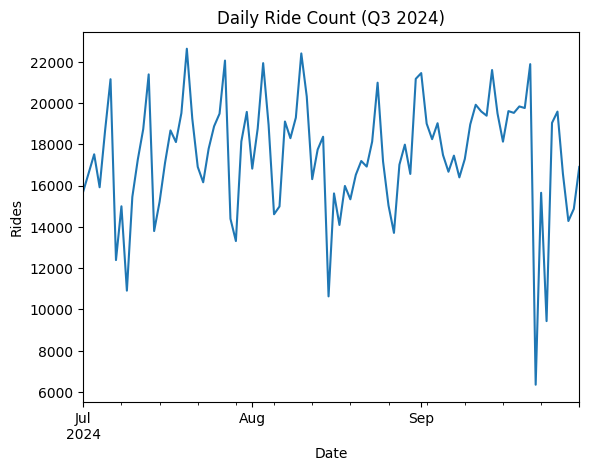

<Figure size 640x480 with 0 Axes>

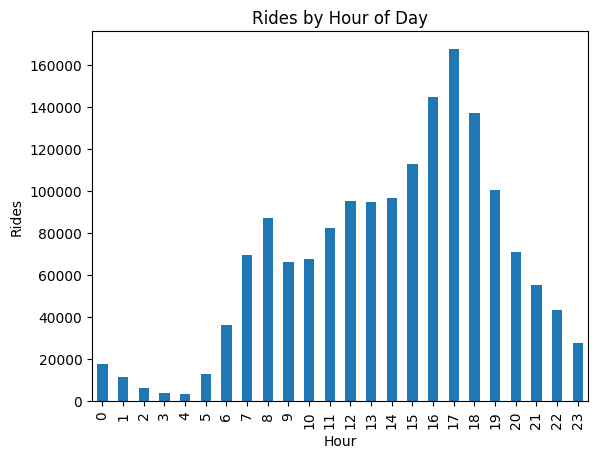

In [9]:
# Cell 8: Visualizations

# Daily Ride Count
df_day = con.execute("""
  SELECT DATE(started_at) AS day, COUNT(*) AS rides
  FROM cleaned_q3 GROUP BY day ORDER BY day
""").df()
plt.figure()
df_day.plot(x='day', y='rides', legend=False)
plt.title("Daily Ride Count (Q3 2024)")
plt.xlabel("Date")
plt.ylabel("Rides")

# Rides by Hour
df_hr = con.execute("""
  SELECT EXTRACT(hour FROM started_at) AS hour, COUNT(*) AS rides
  FROM cleaned_q3 GROUP BY hour ORDER BY hour
""").df()
plt.figure()
df_hr.plot(x='hour', y='rides', kind='bar', legend=False)
plt.title("Rides by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Rides")
